In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import warnings
import lightgbm as lgb
import datetime as dt
import matplotlib.dates as mdates
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error,r2_score
from math import sqrt

In [2]:
%%time
root = '/Users/yuyizhang/Documents/forecasting/Energy_Data/Forecasting Energy Consumption_data/'
holidays=pd.read_csv(root + 'holidays.csv')
metadata=pd.read_csv(root + 'metadata.csv')
train=pd.read_csv(root + 'train.csv')
weather=pd.read_csv(root + 'weather.csv')

CPU times: user 15.6 s, sys: 2.81 s, total: 18.4 s
Wall time: 19 s


In [3]:
holidays = holidays.rename(columns={"Date": "Timestamp"})

In [4]:
holidays['Timestamp']= pd.to_datetime(holidays['Timestamp'],format='%d/%m/%Y')
train['Timestamp']= pd.to_datetime(train['Timestamp'],format='%Y-%m-%d %H:%M:%S')
weather['Timestamp']= pd.to_datetime(weather['Timestamp'],format='%Y-%m-%d %H:%M:%S')

In [5]:
merge_df = pd.merge(train,metadata,how = 'outer',on = ['SiteId'])
merge_df = merge_df.dropna(axis = 0, how = 'any')

In [6]:
del train, metadata

In [7]:
# Below function extracts date related features from datetime
def create_date_featues_train(df):

    df['Year'] = pd.to_datetime(merge_df['Timestamp']).dt.year
    df['Month'] = pd.to_datetime(merge_df['Timestamp']).dt.month
    df['Day'] = pd.to_datetime(merge_df['Timestamp']).dt.day
    df['Hour'] = pd.to_datetime(merge_df['Timestamp']).dt.hour
    df['Minute'] = pd.to_datetime(merge_df['Timestamp']).dt.minute
    
    return df

In [8]:
merge_df = create_date_featues_train(merge_df)
df_train = pd.merge(merge_df,holidays,how = 'outer',on = ['Timestamp'])

In [9]:
df_train['Holiday'] = df_train['Holiday'].replace(np.nan, 0)
df_train = df_train.dropna(axis = 0, how = 'any')

In [10]:
for col in ['Holiday']:
    df_train = pd.get_dummies(df_train, columns=[col])
for col in ['Sampling']:
    df_train = pd.get_dummies(df_train, columns=[col])
for col in ['BaseTemperature']:
    df_train = pd.get_dummies(df_train, columns=[col])
for col in ['MondayIsDayOff']:
    df_train = pd.get_dummies(df_train, columns=[col])
for col in ['TuesdayIsDayOff']:
    df_train = pd.get_dummies(df_train, columns=[col])
for col in ['WednesdayIsDayOff']:
    df_train = pd.get_dummies(df_train, columns=[col])
for col in ['ThursdayIsDayOff']:
    df_train = pd.get_dummies(df_train, columns=[col])
for col in ['FridayIsDayOff']:
    df_train = pd.get_dummies(df_train, columns=[col])
for col in ['SaturdayIsDayOff']:
    df_train = pd.get_dummies(df_train, columns=[col])
for col in ['SundayIsDayOff']:
    df_train = pd.get_dummies(df_train, columns=[col])

In [11]:
df_train.shape

(606539, 134)

In [12]:
df_train_value = pd.DataFrame(df_train.Value.copy())
df_train_value.columns = ["Value"]

In [13]:
# Adding the lag of the target variable from 6 steps back up to 24
for i in range(6, 50):
    df_train_value["lag_{}".format(i)] = df_train_value.Value.shift(i)
    
df_value_lag = df_train_value.drop(columns = ['Value'])
del df_train_value

In [14]:
train_all = pd.concat([df_train,df_value_lag],axis=1)
train_all = train_all.dropna(axis = 0, how = 'any')
train_all = train_all.reset_index(drop=True)

In [15]:
train_all.shape

(606490, 178)

In [94]:
df_1 = train_all[:int(len(train_all)*0.15)]
train_set = df_1[ : int(len(df_1)*0.7)]
test_set = df_1[int(len(df_1)*0.7) : ]

In [95]:
print(train_set.shape)
print(test_set.shape)

(63681, 178)
(27292, 178)


In [96]:
x_train1 = train_set.drop(columns={'obs_id','Timestamp','Value'},axis=1)
y_train1 = train_set.loc[:,['Value']]

x_val1=test_set.drop(columns={'obs_id','Timestamp','Value'},axis=1)
y_val1=test_set.loc[:,['Value']]

In [97]:
import lightgbm as lgb

lgb_merge_df = lgb.LGBMRegressor(objective='regression')
lgb_merge_df.fit(x_train1, y_train1,eval_metric="rmse", 
    eval_set=[(x_train1, y_train1)],
    verbose=True, 
    early_stopping_rounds = 1000)

[1]	training's rmse: 3.49612e+06	training's l2: 1.22229e+13
Training until validation scores don't improve for 1000 rounds
[2]	training's rmse: 3.18866e+06	training's l2: 1.01676e+13
[3]	training's rmse: 2.91518e+06	training's l2: 8.49825e+12
[4]	training's rmse: 2.67606e+06	training's l2: 7.16127e+12
[5]	training's rmse: 2.47866e+06	training's l2: 6.14377e+12
[6]	training's rmse: 2.28376e+06	training's l2: 5.21554e+12
[7]	training's rmse: 2.11848e+06	training's l2: 4.48795e+12
[8]	training's rmse: 1.97879e+06	training's l2: 3.91561e+12
[9]	training's rmse: 1.84273e+06	training's l2: 3.39565e+12
[10]	training's rmse: 1.72149e+06	training's l2: 2.96353e+12
[11]	training's rmse: 1.60924e+06	training's l2: 2.58967e+12
[12]	training's rmse: 1.50868e+06	training's l2: 2.27611e+12
[13]	training's rmse: 1.42732e+06	training's l2: 2.03724e+12
[14]	training's rmse: 1.35189e+06	training's l2: 1.8276e+12
[15]	training's rmse: 1.28871e+06	training's l2: 1.66078e+12
[16]	training's rmse: 1.22311e+0

LGBMRegressor(objective='regression')

In [101]:
from sklearn.metrics import mean_squared_error,r2_score
from math import sqrt

In [102]:
pred_lgb_df=lgb_merge_df.predict(x_val1)

In [103]:
r2_score(y_val1,pred_lgb_df)

0.9719423296293755

In [23]:
import shap

In [24]:
explainer_xgb_static = shap.TreeExplainer(lgb_merge_df)
shap_xgb_values = explainer_xgb_static(x_train1)

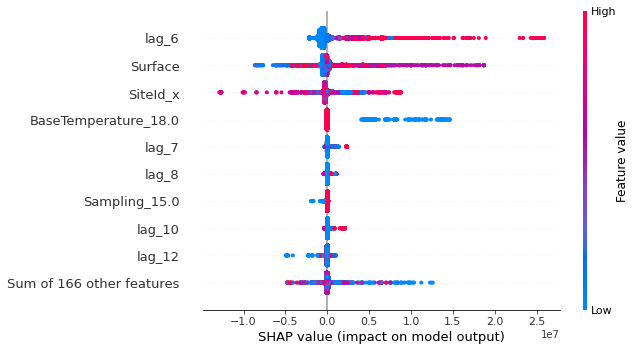

In [25]:
sns.reset_orig()
shap.plots.beeswarm(shap_xgb_values)

In [26]:
df_more = train_all[int(len(df_1)*0.7) : ]

In [27]:
train_more = df_more.drop(columns={'obs_id','Timestamp','Value'},axis=1)
test_more = df_more.loc[:,['Value']]

In [28]:
pred_xgb_more=lgb_merge_df.predict(train_more)

In [29]:
r2_score(test_more,pred_xgb_more)

0.6768239705681515

In [30]:
int(len(pred_xgb_more))

542809

In [82]:
acc = []

for i in range(0,int((len(test_more)-1000)/10)):
    accuracy = r2_score(test_more[0:1000+i*10],pred_xgb_more[0:1000+i*10])
    
    acc.append(accuracy)

    percent = float(i)*10/int(len(test_more)/100)
    sys.stdout.write("%.4f"%percent);
    sys.stdout.write("%\r");
    #sys.stdout.flush();

sys.stdout.write("100%_finish!\r");
sys.stdout.flush();

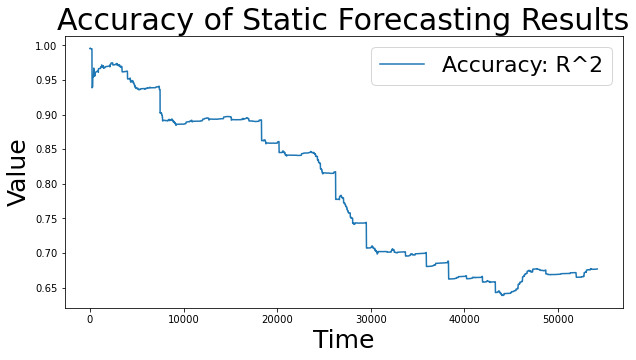

In [83]:
fig = plt.figure(figsize=(10,5))
sns.reset_orig()
plt.title('Accuracy of Static Forecasting Results', fontsize = 30)
plt.plot(acc,label = 'Accuracy: R^2')
plt.xlabel('Time', fontsize = 25)
plt.ylabel('Value', fontsize = 25)
plt.legend(fontsize = 22)

plt.show()

In [34]:
df_features = train_all.drop(columns={'obs_id','Timestamp','Value'},axis=1)
df_target = train_all.loc[:,['Value']]

In [35]:
lgb_merge_df = lgb.LGBMRegressor(objective='regression')

In [36]:
L = int(len(df_1)*0.7)
S = int(len(df_1)*0.3)

In [37]:
prediction_results = []

for i in range(0,int(len(test_more)/S)):
    df_x_train = df_features[ i*S : L + i*S]
    df_y_train = df_target[ i*S : L + i*S]
    
    df_x_val = df_features[L + i*S : L + i*S + S]
    df_y_val = df_target[L + i*S : L + i*S + S]
    
    
    
    lgb_merge_df.fit(df_x_train, df_y_train,eval_metric="rmse", 
        eval_set=[(df_x_train, df_y_train)],
        verbose=False,
        early_stopping_rounds = 1000)
    
    pred_dynamic=lgb_merge_df.predict(df_x_val)
    
    prediction_results.append(pred_dynamic)

    percent = float(i)*100/float(len(test_more)/S)
    sys.stdout.write("%.4f"%percent);
    sys.stdout.write("%\r");
    sys.stdout.flush();

sys.stdout.write("100%_finish!\r");
sys.stdout.flush();

In [38]:
pred = np.array(prediction_results)

In [39]:
pred_results =pred.flatten()

In [44]:
int(len(pred_results)/1000)

518

In [80]:
acc_dymanic = []

for i in range(0,int((len(pred_results)-1000)/10)):
    accuracy_dy = r2_score(test_more[0:1000+i*10],pred_results[0:1000+i*10])
    
    acc_dymanic.append(accuracy_dy)
    
    percent = float(i)*10/int(len(test_more)/100)
    sys.stdout.write("%.4f"%percent);
    sys.stdout.write("%\r");
    #sys.stdout.flush();

sys.stdout.write("100%_finish!\r");
sys.stdout.flush();

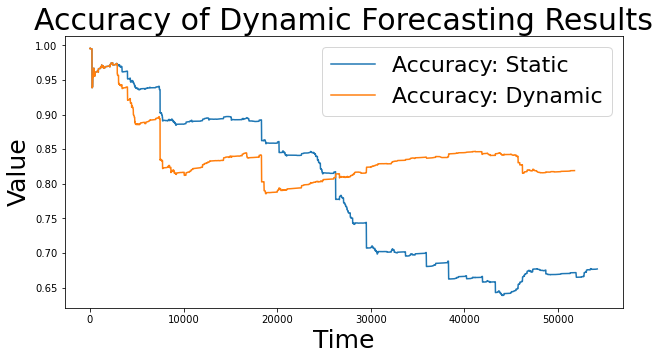

In [84]:
fig = plt.figure(figsize=(10,5))
plt.title('Accuracy of Dynamic Forecasting Results', fontsize = 30)
plt.plot(acc,label = 'Accuracy: Static')
plt.plot(acc_dymanic,label = 'Accuracy: Dynamic')
plt.xlabel('Time', fontsize = 25)
plt.ylabel('Value', fontsize = 25)
plt.legend(fontsize = 22)

plt.show()

In [48]:
import shap

In [49]:
df_shap_results = pd.DataFrame()

for i in range(0,int(len(test_more)/S)):
    df_x_train = df_features[ i*S : L + i*S]
    df_y_train = df_target[ i*S : L + i*S]
    
    df_x_val = df_features[L + i*S : L + i*S + S]
    df_y_val = df_target[L + i*S : L + i*S + S]
    
    lgb_merge_df.fit(df_x_train, df_y_train,eval_metric="rmse", 
        eval_set=[(df_x_train, df_y_train)],
        verbose=False,
        early_stopping_rounds = 1000)
    
    explainer_xgb_dynamic = shap.TreeExplainer(lgb_merge_df)
    shap_xgb_values = explainer_xgb_dynamic(df_x_train)
    shap_xgb_values = pd.DataFrame(shap_xgb_values.values)
    
    shap_values_update = []
    for n in range(0, len(shap_xgb_values.columns)):
        each_shap_value = (abs(shap_xgb_values[n]).sum())/len(shap_xgb_values)
        
        shap_values_update.append(each_shap_value)
    
    df_shap_results[i] = shap_values_update
    del shap_values_update
    
    percent = float(i)*100/float(len(test_more)/S)
    sys.stdout.write("%.4f"%percent);
    sys.stdout.write("%\r");
    sys.stdout.flush();

sys.stdout.write("100%_finish!\r");
sys.stdout.flush();

In [109]:
prediction_results_up = []

df_shap_update = pd.DataFrame()
df_cols = pd.DataFrame(x_train1.columns)
df_shap_update['Features'] = df_cols[0]

for i in range(0,len(df_shap_results.columns)) :
    
    df_shap_update['shap_value'] = df_shap_results[i]
    df_shap = df_shap_update.sort_values(by = 'shap_value').reset_index()
    
    df_x_train = df_features[ i*S : L + i*S]
    df_y_train = df_target[ i*S : L + i*S]
    
    df_x_val = df_features[L + i*S : L + i*S + S]
    df_y_val = df_target[L + i*S : L + i*S + S]
    
    

    remove_features = df_shap['Features'][0:165].values.tolist()
    
    df_x_train_up = df_x_train.drop(remove_features,axis=1)
    df_x_val_up = df_x_val.drop(remove_features,axis=1)
    
    lgb_merge_df.fit(df_x_train_up, df_y_train,eval_metric="rmse", 
        eval_set=[(df_x_train_up, df_y_train)],
        verbose=False,
        early_stopping_rounds = 1000)
    
    pred_dynamic_up=lgb_merge_df.predict(df_x_val_up)
    
    prediction_results_up.append(pred_dynamic_up)
    
    percent = float(i)*100/float(len(df_shap_results.columns))
    sys.stdout.write("%.4f"%percent);
    sys.stdout.write("%\r");
    sys.stdout.flush();

sys.stdout.write("100%_finish!\r");
sys.stdout.flush();

In [110]:
pred_up = np.array(prediction_results_up)

In [111]:
pred_results_up =pred_up.flatten()

In [112]:
acc_dymanic_up = []

for i in range(0,int((len(pred_results_up)-1000)/10)):
    accuracy_dy_up = r2_score(test_more[0:1000+i*10],pred_results_up[0:1000+i*10])
    
    acc_dymanic_up.append(accuracy_dy_up)
    
    percent = float(i)*10/float((len(test_more)/100))
    sys.stdout.write("%.4f"%percent);
    sys.stdout.write("%\r");
    #sys.stdout.flush();

sys.stdout.write("100%_finish!\r");
sys.stdout.flush();

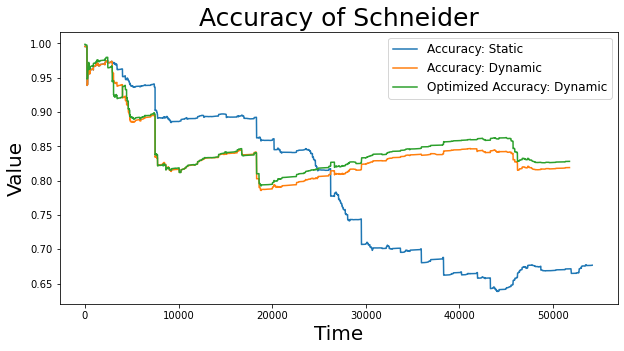

In [122]:
fig = plt.figure(figsize=(10,5))
plt.title('Accuracy of Schneider', fontsize = 25)
plt.plot(acc,label = 'Accuracy: Static')
plt.plot(acc_dymanic,label = 'Accuracy: Dynamic')
plt.plot(acc_dymanic_up,label = 'Optimized Accuracy: Dynamic')
plt.xlabel('Time', fontsize = 20)
plt.ylabel('Value', fontsize = 20)
plt.legend(fontsize = 12)

plt.show()

In [114]:
avg_acc = np.mean(acc)

In [115]:
avg_acc

0.7867340945289639

In [116]:
avg_acc_dymanic = np.mean(acc_dymanic)

In [117]:
avg_acc_dymanic

0.8397902792264055

In [118]:
avg_acc_dymanic_up = np.mean(acc_dymanic_up)

In [119]:
avg_acc_dymanic_up

0.8476015578221797